In [528]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime,timedelta,date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')


data=pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
print(data.head())
data.describe().iloc[:,:2]

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  


,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [529]:

country_list=sorted(list(set(data['Country'])), key=lambda x: x[0])
country_list_index={country:i for i,country in enumerate(country_list)}

for country in country_list:
    country_column=data['Country'] 
    country_column[data['Country']==country]=country_list_index[country]

data['Country']=country_column
data.drop(columns=[ 'StockCode', 'Description'])

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,6,01-12-2010 08:26,2.55,17850.0,37
1,536365,6,01-12-2010 08:26,3.39,17850.0,37
2,536365,8,01-12-2010 08:26,2.75,17850.0,37
3,536365,6,01-12-2010 08:26,3.39,17850.0,37
4,536365,6,01-12-2010 08:26,3.39,17850.0,37
...,...,...,...,...,...,...
541904,581587,12,09-12-2011 12:50,0.85,12680.0,12
541905,581587,6,09-12-2011 12:50,2.10,12680.0,12
541906,581587,4,09-12-2011 12:50,4.15,12680.0,12
541907,581587,4,09-12-2011 12:50,4.15,12680.0,12


In [530]:
missing_code=data[data['CustomerID'].isna()==True]

data=pd.DataFrame(data[data['CustomerID'].isna()==False][data['Quantity']>0])

customer_list_codes=list(set(data['CustomerID']))

order_amounts=[]
price_amount=[]
#print(data['UnitPrice'].quantile(0.90))
#data=pd.DataFrame(data[data['UnitPrice']<data['UnitPrice'].quantile(0.90)] )


for code in customer_list_codes:
    
    mask=data['CustomerID']==code
    order_amounts.append((len(data[mask]), np.sum(data['Quantity'][mask]  )))
    quantity=data['Quantity'][mask]
    price=data['UnitPrice'][mask]
    
    price_amount.append(sum(quantity*price))

order_amounts=np.array(order_amounts)

average_order_amount=np.sum(order_amounts[:,0])/len(customer_list_codes)
average_order_size=np.sum(order_amounts[:,1])/len(customer_list_codes)
average_order_revenue=np.sum(price_amount)/len(customer_list_codes)
total_revenue=np.sum(price_amount)


print('the average person do',np.round(average_order_amount),'orders, buy', np.round(average_order_size), 'objects','and generate a revenue of: ',np.round(average_order_revenue))
print('for a gross total revenue of: ', np.round(total_revenue,2),'$')

the average person do 92.0 orders, buy 1194.0 objects and generate a revenue of:  2054.0
for a gross total revenue of:  8911407.9 $


In [531]:


rev_for_every_country={}
for country_code in country_list_index.values():
    mask=data['Country'] == country_code
    revenue_per_country= int(np.sum(data['Quantity'][mask]*data['UnitPrice'][mask]))
    percentage=np.round((revenue_per_country/total_revenue)*100,2)
    population=len(data[mask])
    if population > 0:
        average_spender=np.round(revenue_per_country/population,2)
    else:
        average_spender=0
    rev_for_every_country[country_list[country_code]]=[revenue_per_country,percentage,average_spender,population]

dl=pd.DataFrame.from_dict(rev_for_every_country,orient='index', columns=['Revenue','Percentage/total','AVG Revenue', 'Population'])
print(dl.sort_values(by=['Revenue'], ascending=False))

                      Revenue  Percentage/total  AVG Revenue  Population
United Kingdom        7308391             82.01        20.63      354345
Netherlands            285446              3.20       120.80        2363
EIRE                   265545              2.98        36.69        7238
Germany                228867              2.57        25.31        9042
France                 209024              2.35        25.06        8342
Australia              138521              1.55       116.90        1185
Spain                   61577              0.69        24.78        2485
Switzerland             56443              0.63        30.64        1842
Belgium                 41196              0.46        20.28        2031
Sweden                  38378              0.43        85.10         451
Japan                   37416              0.42       116.56         321
Norway                  36165              0.41        33.74        1072
Portugal                33439              0.38    

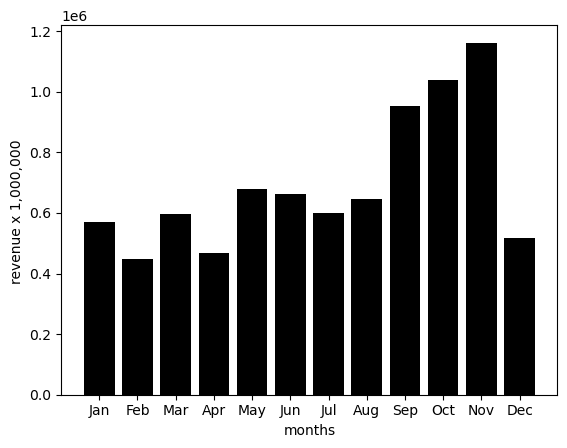

In [532]:
customer_list_codes=list(set(data['CustomerID']))
data['Revenue']=data['Quantity']*data['UnitPrice']
start_date = datetime(2010, 12, 1)
end_date = datetime(2011, 12, 9)

delta = timedelta(days=32)
previous=[]
i=0

month_abbreviations = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Y=[]
while start_date <= end_date+delta:
    date=start_date.strftime("%Y-%m-%d")
   
    y1,m1,g1=date.split('-')
    previous.append((m1,y1))

    filtered=data['InvoiceDate'] 

    mask=[]
    for row in filtered:
        current_date,_=row.split(' ')
       
        g2,m2,y2=current_date.split('-')
        if i==0:
            if int(m1)>=int(m2) and int(y1)>=int(y2):
                mask.append(True)
            else:
                mask.append(False)
        else:
            if start_date+delta>= end_date:
                if int(m1)>=int(m2) and int(m2)>int(previous[i-1][0]) and int(y1)>=int(y2) and int(y2)>=int(previous[i-1][1]):
                    mask.append(True)
                else:
                    mask.append(False)
            else:
                if int(m1)%12>=int(m2)%12 and int(m2)%12>int(previous[i-1][0])%12 and int(y1)>=int(y2) and int(y2)>=int(previous[i-1][1]):
                    mask.append(True)
                else:
                    mask.append(False)
            

    team = data[mask].groupby('InvoiceDate').agg(
        total_revenue=('Revenue','sum')
    )
    Y.append(np.sum(team['total_revenue']))
  


    i+=1
    start_date += delta

plt.bar(month_abbreviations,Y[1:], color='black')
plt.ylabel('revenue x 1,000,000 ')
plt.xlabel('months')
plt.show()


Text(0.5, 0, 'Monetary')

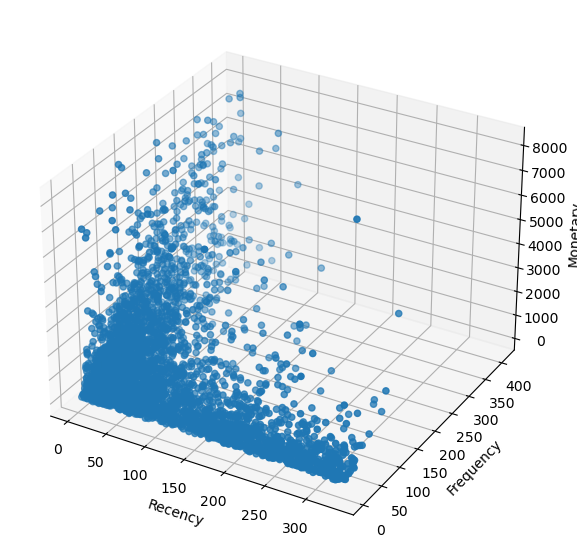

In [533]:

customer_list_codes=list(set(data['CustomerID']))
RFM={}
current_date = datetime(2011, 12, 9)

for code in customer_list_codes:
    mask=data['CustomerID']==code
    date, hours=data['InvoiceDate'][mask].iloc[-1].split()

    d,m,y=date.split('-')
    date=datetime(int(y), int(m), int(d))
    number_of_transaction=len(data[mask])
    total_amount=np.sum(data['Quantity'][mask]*data['UnitPrice'][mask])
    
    RFM[code]=[(current_date-date).days,number_of_transaction, total_amount]


RFM=pd.DataFrame.from_dict(RFM,orient='index',columns=['Recency','Frequency','Monetary'])
hr,hf,hm=RFM.quantile(0.97)

lr,lf,lm=RFM.quantile(0.03)

RFM = pd.DataFrame(RFM[(RFM['Recency'] < hr) & (RFM['Recency'] > lr) & (RFM['Frequency']<hf )& (RFM['Frequency']>lf )& (RFM['Monetary']<hm )& (RFM['Monetary']>lm ) ])

X=[]
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

ax.scatter(RFM.iloc[:,0], RFM.iloc[:,1], RFM.iloc[:,2])
ax.set_xlabel(f'{RFM.columns[0]}')
ax.set_ylabel(f'{RFM.columns[1]}')
ax.set_zlabel(f'{RFM.columns[2]}')

18 18


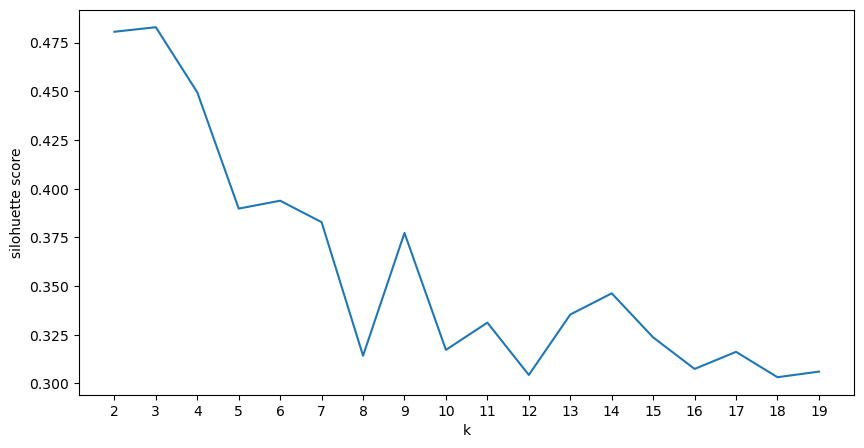

In [534]:
scaler=StandardScaler().fit(RFM)



RFM_scaled=pd.DataFrame(scaler.transform(RFM), columns=['Recency','Frequency','Monetary'])
scores=[]
for x in range(2,20):
    cm=KMeans(n_clusters=x)
    s_score=silhouette_score(RFM_scaled,cm.fit_predict(RFM_scaled))
    scores.append(s_score)

print(len(range(2,20)), len(scores))
plt.figure(figsize=(10,5))
plt.plot(range(2,20), scores)
plt.xticks(range(2,20))
plt.xlabel('k')
plt.ylabel('silohuette score')
plt.show()

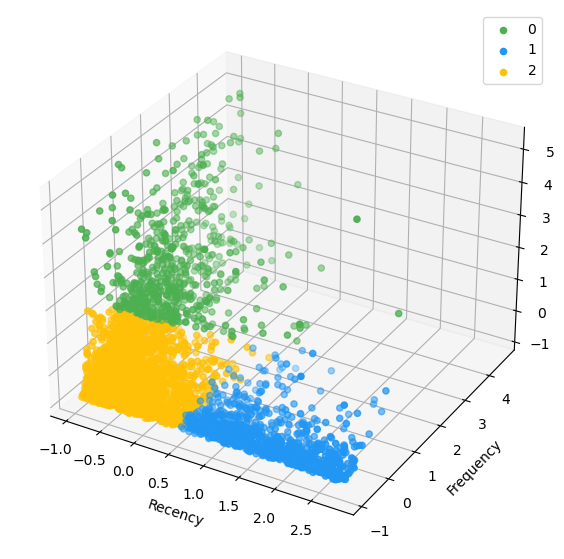

In [535]:
kmeans=KMeans(n_clusters=3).fit(RFM_scaled)

RFM_scaled['label']=kmeans.labels_
RFM['label']=kmeans.labels_
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
colors = ['#4CAF50', '#2196F3', '#FFC107']
for label in range(0,3):
    mask=RFM_scaled['label']==label
 
    ax.scatter(RFM_scaled[mask].iloc[:,0], RFM_scaled[mask].iloc[:,1], RFM_scaled[mask].iloc[:,2], label=label, color=colors[label])


ax.set_xlabel(RFM.columns[0])
ax.set_ylabel(RFM.columns[1])
ax.set_zlabel(RFM.columns[2])    
ax.legend()

In [536]:
t_revenue=[]
for x in range(0,3):
    mask=RFM['label']==x
    total_revenue_for_cluster=int(np.round(np.sum(RFM['Monetary'][mask])))
    total_frequency_for_cluster=np.round(np.sum(RFM['Frequency'][mask]))
    print(f'Cluster {x} generated this revenue: {total_revenue_for_cluster}$', 'with ', total_frequency_for_cluster ,'transaction', f'so we have a transaction value of {round(total_revenue_for_cluster/total_frequency_for_cluster,2)}')
    t_revenue.append(total_revenue_for_cluster)

for i,r in enumerate(t_revenue):
    print(f'Cluster {i} accounted for', round(r/np.sum(t_revenue)*100,2), '% of the revenue')

Cluster 0 generated this revenue: 2163807$ with  121107 transaction so we have a transaction value of 17.87
Cluster 1 generated this revenue: 394207$ with  24356 transaction so we have a transaction value of 16.19
Cluster 2 generated this revenue: 1807722$ with  109794 transaction so we have a transaction value of 16.46
Cluster 0 accounted for 49.56 % of the revenue
Cluster 1 accounted for 9.03 % of the revenue
Cluster 2 accounted for 41.41 % of the revenue
